In [42]:
import yfinance as yf 
import pandas as pd 
from datetime import datetime, timedelta 
import numpy as np 
from scipy.optimize import minimize

In [43]:
tickers = ['SPY','NVDA','AAPL','MSFT','AMD', 'GOOGL', 'AMZN', 'TSLA', 'MU']
end_date = datetime.today()
start_date = end_date - timedelta(days = 2*365)

In [44]:
# Robust multi-ticker download with adjusted prices and MultiIndex handling
raw = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,           # adjusted already lives in 'Close'
    group_by="column",
    progress=False
)

# Extract adjusted price level for both old/new yfinance behaviors
if isinstance(raw.columns, pd.MultiIndex):
    lvl0 = raw.columns.get_level_values(0)
    want = "Adj Close" if "Adj Close" in lvl0 else "Close"
    adj_close_df = raw.xs(want, axis=1, level=0)
else:
    want = "Adj Close" if "Adj Close" in raw.columns else "Close"
    adj_close_df = raw[[want]]
    # If a single ticker was provided, rename the column to the ticker symbol
    if isinstance(tickers, list) and len(tickers) == 1:
        adj_close_df = adj_close_df.rename(columns={want: tickers[0]})

# Optional: align to business days and fill small gaps
adj_close_df = (
    adj_close_df.sort_index()
                .asfreq("B")
                .ffill(limit=3)
                .dropna(how="all")
)

print(f"Adjusted close DataFrame shape: {adj_close_df.shape}")
print(f"Columns in adj_close_df: {list(adj_close_df.columns)}")
if not adj_close_df.empty:
    print(f"Date range: {adj_close_df.index[0]} to {adj_close_df.index[-1]}")
    print(adj_close_df.head())
else:
    print("Error: No data was downloaded. Check tickers/date range/network.")

Adjusted close DataFrame shape: (522, 9)
Columns in adj_close_df: ['AAPL', 'AMD', 'AMZN', 'GOOGL', 'MSFT', 'MU', 'NVDA', 'SPY', 'TSLA']
Date range: 2023-08-10 00:00:00 to 2025-08-08 00:00:00
Ticker            AAPL         AMD        AMZN       GOOGL        MSFT  \
Date                                                                     
2023-08-10  176.205765  110.230003  138.559998  128.916840  317.985413   
2023-08-11  176.265259  107.570000  138.410004  128.787598  316.094849   
2023-08-14  177.920944  111.980003  140.570007  130.547073  319.078461   
2023-08-15  175.928177  111.349998  137.669998  129.006302  316.931793   
2023-08-16  175.055756  107.190002  135.070007  127.932739  316.162170   

Ticker             MU       NVDA         SPY        TSLA  
Date                                                      
2023-08-10  64.820641  42.361938  434.349060  245.339996  
2023-08-11  63.760765  40.829880  434.095795  242.649994  
2023-08-14  67.633751  43.726089  436.492004  239.7599

In [45]:
from typing import Any

class Console:
    @staticmethod
    def log(*args: Any) -> None:
        print(*args)

console = Console()
console.log("Code is", "Poetry")

Code is Poetry


In [46]:
# Compute log returns using diff of logs (fast & stable)
if adj_close_df.empty:
    print("Error: adj_close_df is empty; cannot compute log returns.")
else:
    log_returns = np.log(adj_close_df).diff().dropna(how="all")
    print(f"Log returns shape: {log_returns.shape}")
    if not log_returns.empty:
        print(f"Date range: {log_returns.index[0]} to {log_returns.index[-1]}")
        print("First few log returns:\n", log_returns.head())
    else:
        print("Warning: Log returns DataFrame is empty after diff/dropna.")

Log returns shape: (521, 9)
Date range: 2023-08-11 00:00:00 to 2025-08-08 00:00:00
First few log returns:
 Ticker          AAPL       AMD      AMZN     GOOGL      MSFT        MU  \
Date                                                                     
2023-08-11  0.000338 -0.024427 -0.001083 -0.001003 -0.005963 -0.016486   
2023-08-14  0.009349  0.040179  0.015485  0.013569  0.009395  0.058969   
2023-08-15 -0.011263 -0.005642 -0.020846 -0.011873 -0.006750 -0.044166   
2023-08-16 -0.004971 -0.038075 -0.019066 -0.008357 -0.002431 -0.017137   
2023-08-17 -0.014662 -0.025990 -0.008103  0.009435 -0.011047 -0.010330   

Ticker          NVDA       SPY      TSLA  
Date                                      
2023-08-11 -0.036836 -0.000583 -0.011025  
2023-08-14  0.068531  0.005505 -0.011982  
2023-08-15  0.004265 -0.011717 -0.028772  
2023-08-16 -0.010386 -0.007365 -0.032103  
2023-08-17 -0.003271 -0.007649 -0.028688  


In [47]:
# Annualized covariance matrix from log returns
try:
    if 'log_returns' not in globals() or log_returns.empty:
        print("Error: log_returns is not available or empty; compute it first.")
    else:
        cov_matrix = log_returns.cov() * 252
        print("Covariance matrix shape:", cov_matrix.shape)
        print("Tickers:", list(cov_matrix.columns))
        print("\nHead of covariance matrix:\n", cov_matrix.head())
except NameError:
    print("Error: log_returns not defined; run the log-returns cell first.")

Covariance matrix shape: (9, 9)
Tickers: ['AAPL', 'AMD', 'AMZN', 'GOOGL', 'MSFT', 'MU', 'NVDA', 'SPY', 'TSLA']

Head of covariance matrix:
 Ticker      AAPL       AMD      AMZN     GOOGL      MSFT        MU      NVDA  \
Ticker                                                                         
AAPL    0.073306  0.058545  0.042725  0.035950  0.031169  0.051541  0.051812   
AMD     0.058545  0.237330  0.074032  0.067118  0.051398  0.141993  0.152600   
AMZN    0.042725  0.074032  0.093170  0.053406  0.044302  0.073284  0.080768   
GOOGL   0.035950  0.067118  0.053406  0.084060  0.034053  0.053274  0.064357   
MSFT    0.031169  0.051398  0.044302  0.034053  0.048468  0.048429  0.060732   

Ticker       SPY      TSLA  
Ticker                      
AAPL    0.030549  0.075357  
AMD     0.051984  0.121846  
AMZN    0.036095  0.080660  
GOOGL   0.028275  0.070642  
MSFT    0.025379  0.053027  


In [48]:
# Portfolio performance metrics
import numpy as np

def standard_deviation(weights, cov_matrix):
    w = np.asarray(weights)
    return np.sqrt(w.T @ cov_matrix @ w)

def expected_return(weights, log_returns):
    w = np.asarray(weights)
    return np.sum(log_returns.mean().values * w) * 252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate=0.0):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [49]:
# Portfolio optimization (maximize Sharpe)
from scipy.optimize import minimize

risk_free_rate = 0.02  # 2%


def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

n_assets = len(adj_close_df.columns)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
bounds = tuple((0.0, 0.4) for _ in range(n_assets))
initial_weights = np.array([1.0 / n_assets] * n_assets)

if 'log_returns' in globals() and not log_returns.empty:
    optimized_results = minimize(
        neg_sharpe_ratio,
        initial_weights,
        args=(log_returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds,
    )
    print("Optimization success:", optimized_results.success)
    if not optimized_results.success:
        print("Message:", optimized_results.message)
else:
    print("Error: compute log_returns and cov_matrix before optimization.")

Optimization success: True


Optimal Weights:
AAPL: 0.0000
AMD: 0.0000
AMZN: 0.0000
GOOGL: 0.0000
MSFT: 0.3722
MU: 0.0000
NVDA: 0.4000
SPY: 0.2278
TSLA: 0.0000

Expected Annual Return: 0.4142
Expected Volatility: 0.2842
Sharpe Ratio: 1.3873


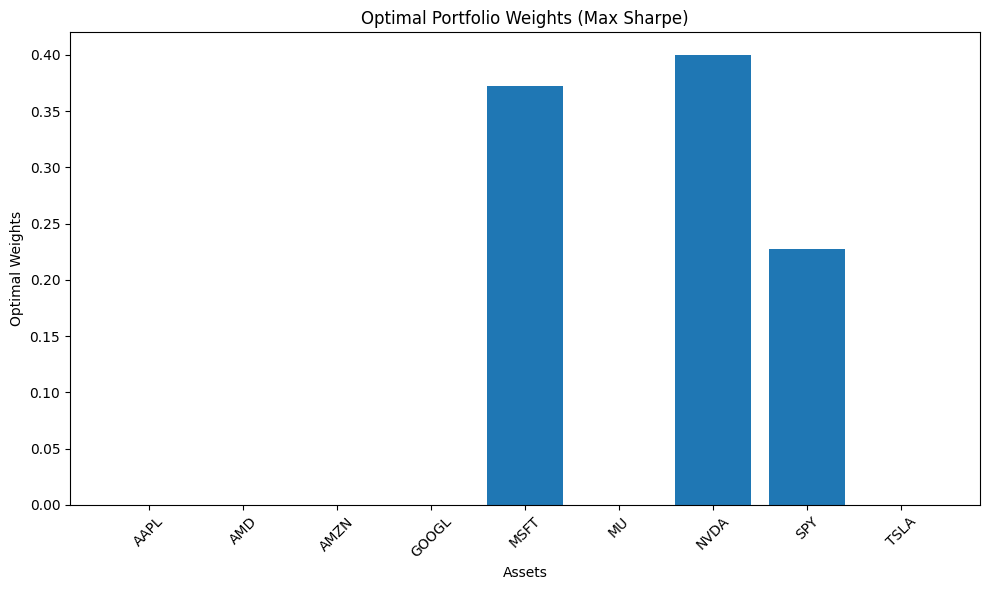

In [50]:
# Analyze the optimal portfolio and plot weights
import matplotlib.pyplot as plt

try:
    optimal_weights = optimized_results.x
    print("Optimal Weights:")
    for t, w in zip(adj_close_df.columns, optimal_weights):
        print(f"{t}: {w:.4f}")

    opt_ret = expected_return(optimal_weights, log_returns)
    opt_vol = standard_deviation(optimal_weights, cov_matrix)
    opt_sr = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

    print(f"\nExpected Annual Return: {opt_ret:.4f}")
    print(f"Expected Volatility: {opt_vol:.4f}")
    print(f"Sharpe Ratio: {opt_sr:.4f}")

    plt.figure(figsize=(10, 6))
    plt.bar(adj_close_df.columns, optimal_weights)
    plt.xlabel('Assets')
    plt.ylabel('Optimal Weights')
    plt.title('Optimal Portfolio Weights (Max Sharpe)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Optimization results not available:", str(e))

In [51]:
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")
log = logging.getLogger("console")

log.info("Code is Poetry")

2025-08-09 19:32:05,886 INFO: Code is Poetry
